In [1]:
# установка библиотеки, необходимой для декодирования CTC-loss в разделе с LSTM

import os
os.chdir('/content/')
!git clone --recursive https://github.com/parlance/ctcdecode.git
os.chdir('/content/ctcdecode/')
!pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 1102, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1102 (delta 16), reused 32 (delta 14), pack-reused 1063
Receiving objects: 100% (1102/1102), 782.27 KiB | 15.34 MiB/s, done.
Resolving deltas: 100% (529/529), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 14147, done.        
remote: Counting objects: 100% (460/460), done.        
remote: Compressing objects: 100% (320/320), done.        
remote: Total 14147 (delta 15

In [5]:
os.chdir('/content/')
!wget https://github.com/avyuga/captcha_recognition/raw/main/captcha.zip


--2023-05-26 07:31:04--  https://github.com/avyuga/captcha_recognition/raw/main/captcha.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/avyuga/captcha_recognition/main/captcha.zip [following]
--2023-05-26 07:31:04--  https://raw.githubusercontent.com/avyuga/captcha_recognition/main/captcha.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9127102 (8.7M) [application/zip]
Saving to: ‘captcha.zip’

captcha.zip         100%[===================>]   8.70M  --.-KB/s    in 0.1s    

2023-05-26 07:31:05 (79.3 MB/s) - ‘captcha.zip’ saved [9127102/9127102]



In [6]:
# извлекаем файл
import os 
from zipfile import ZipFile

with ZipFile('/content/captcha.zip', 'r') as zipObj:
   zipObj.extractall('/content/')

os.chdir('/content/captcha/')

In [7]:
import numpy as np
from torch.utils.data import Dataset
from torchvision.io import read_image

from pathlib import Path

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.io import ImageReadMode
from torchvision import transforms

import cv2
from tqdm import tqdm 

import matplotlib.pyplot as plt

In [8]:
from ctcdecode import CTCBeamDecoder

In [9]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [10]:
# список и словарь из символов, которые будут использоваться далее
vocabulary = ['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
char2num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

## Подготовка данных

In [11]:
cwd = Path.cwd()
labels = []
for item in cwd.iterdir():
    labels += [item.stem]
print(f"Number of objects: {len(labels)}")

Number of objects: 1070


In [12]:
# так как часть файлов в формате .jpg, то удобно перевести в формат .png для единообразия
for item in cwd.iterdir():
    item.rename(item.with_suffix('.png'))

img = cv2.imread(str(item))
print(img.shape)

(50, 200, 3)


Создаем класс `captcha_dataset`, наследуемый от `torch.utils.data.Dataset`, который загружает изображения в объект и применяет трансформации. Для корректной работы алгоритмов нужно обрезать края, содержащие фон.


In [15]:
class captcha_dataset(Dataset):
    def __init__(self, labels_txt):
        self.labels_txt = labels_txt
        self.transform = True

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels_txt[idx]
        img_path = f"{label}.png"
        image = read_image(img_path, ImageReadMode.RGB)
        label_num = list(map(lambda l: char2num[l], list(label)))
        if self.transform:
            image = transforms.functional.crop(image, 0, 25, 50, 125)
            image = image.type(torch.float32)
            image = transforms.functional.resize(image, size=(50,200), antialias=False)
            image = transforms.functional.normalize(image, (128, 128, 128), (255, 255, 255))
            # image = self.transform(image)
        return image, label_num

In [16]:
full_dataset = captcha_dataset(labels_txt=labels)
train_idx_set, test_idx_set = train_test_split(
    np.arange(len(labels)), test_size=0.3, random_state=42, shuffle=True)

train_dataset = Subset(full_dataset, train_idx_set)
test_dataset = Subset(full_dataset, test_idx_set)


Сравнение исходного и обрезанного изображения:

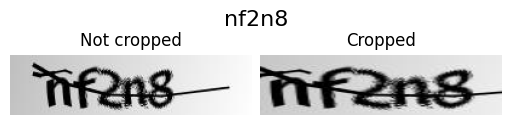

In [17]:
figure, axes = plt.subplots(1, 2, figsize=(5,3), constrained_layout=True)
sample_idx = np.random.randint(len(labels), size=1)
img, label_num = full_dataset[int(sample_idx)]
label_list = list(map(lambda l: vocabulary[l], list(label_num)))
label = "".join(label_list) 
img_not_cropped = cv2.imread(f"{label}.png", cv2.IMREAD_UNCHANGED)

axes[0].imshow(img_not_cropped, cmap='gray')
axes[1].imshow((img.permute([1, 2, 0])+0.5).numpy().clip(0,1), cmap="gray")

axes[0].axis("off")
axes[1].axis("off")

axes[0].set_title("Not cropped")
axes[1].set_title("Cropped")
figure.suptitle(label, fontsize=16, y=0.75)

plt.show()

Больше примеров изображений:

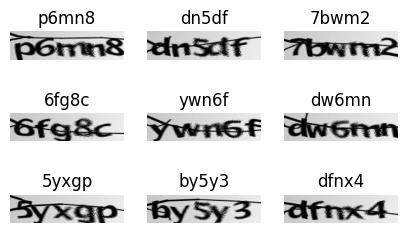

In [18]:
figure, axes = plt.subplots(3, 3, figsize=(5,3))
for i in range(0, 3 * 3):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label_num = train_dataset[sample_idx]
    label_list = list(map(lambda l: vocabulary[l], list(label_num)))
    label = "".join(label_list) 
    axes[i//3, i%3].imshow((img.permute([1, 2, 0])+0.5).numpy().clip(0,1), cmap="gray")
    axes[i//3, i%3].set_title(str(label))
    axes[i//3, i%3].axis("off")
plt.show()

## Вспомогательные классы и функции
Необходимы для удобного подсчета средней потери и точности за батч, а также для логгирования

In [19]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

In [20]:
def log(mode, epoch, loss_meter=None, accuracy_meter=None):
    line = f"[{mode}] Epoch: {(epoch+1):d}"
    if loss_meter:
        loss_line = f" ==== Loss: {loss_meter.value():.5f}"
        line += loss_line
    if accuracy_meter:
        acc_line = f" ==== Accuracy: {accuracy_meter.value():.5f}"
        line += acc_line
    print(line)
    

## CNN

Первый способ решения поставленной задачи - сверточная нейронная сеть. Для распознавания каптчи достаточно простейшей архитектуры, состоящей из двух сверточных блоков, которые могут также иметь нормализацию или Dropout, а затем линейный блок. У линейного блока вывод многомерный, так как для каждой из 5 букв 19 вариантов.

В качестве потери используется `CrossEntropyLoss`, а точность считается как среднее число верно предсказанных букв на батч.

In [21]:
def accuracy_cnn(outputs, labels):
    labels = torch.argmax(labels, dim=2)
    preds = torch.argmax(outputs, dim=2)
    return torch.tensor(torch.sum(preds == labels).item() / (preds.size()[0]*preds.size()[1]))


In [22]:
class CNN_model(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), padding=1)
        nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        nn.init.xavier_normal_(self.conv2.weight)

        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)

        self.linear1 = nn.Linear(64*12*10, 64, bias=False)
        nn.init.xavier_normal_(self.linear1.weight)
        self.linear2 = nn.Linear(64, 19, bias=False)
        nn.init.xavier_normal_(self.linear2.weight)        

        if 'is_batchnorm' in params.keys():
            self.is_batchnorm = params['is_batchnorm']
        if 'is_dropout' in params.keys():
            self.is_dropout = params['is_dropout']
            self.dropout_coeffs = [0.5, 0.5]
            if 'dropout_coeffs' in params.keys():
                self.dropout_coeffs = params['dropout_coeffs']
   
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.is_batchnorm:
            x = self.batch1(x)
        x = self.pool(x)
        if self.is_dropout:
            x = nn.Dropout(p=self.dropout_coeffs[0])(x)


        x = self.conv2(x)
        x = F.relu(x)
        if self.is_batchnorm:
            x = self.batch2(x)
        x = self.pool(x)
        if self.is_dropout:
            x = nn.Dropout(p=self.dropout_coeffs[1])(x)
        
        N = x.shape[0]
        x = x.permute(0, 3, 2, 1)
        x = x.reshape(N, 5, -1)

        x = self.linear1(x)
        x = F.relu(x)
        scores = self.linear2(x)

        return scores


In [23]:
def train_test_cnn(model, loaders, optimizer, criterion, epochs=1):
    model = model.to(device)

    loss_meter = {'train': ValueMeter(), 'test': ValueMeter()}
    accuracy_meter = {'train': ValueMeter(), 'test': ValueMeter()}

    loss_track = {'train': [], 'test': []}
    accuracy_track = {'train': [], 'test': []}

    for epoch in range(epochs):
        for mode in ['train', 'test']:
            with torch.set_grad_enabled(mode == 'train'):
                model.train() if mode == 'train' else model.eval()
                for x, y in tqdm(loaders[mode]):
                    x = x.to(device, dtype=dtype)  # move to device, e.g. GPU
                
                    y = torch.stack(y, dim=1).to(device, dtype=torch.long)
                    scores = model(x)
                    groundtruth_probs = torch.zeros(scores.size())
                    groundtruth_probs[torch.arange(y.size()[0])[:, None], torch.arange(y.size()[1])[None, :], y] = 1
                    groundtruth_probs = groundtruth_probs.to(device, dtype=torch.float)
                    
                    loss = criterion(scores.permute([0, 2, 1]), y)

                    acc = accuracy_cnn(scores, groundtruth_probs)

                    if mode == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    batch_size = y.shape[0]

                    loss_meter[mode].add(loss.item(), batch_size)
                    accuracy_meter[mode].add(acc.item(), batch_size)

            log(mode, epoch, loss_meter=loss_meter[mode], accuracy_meter=accuracy_meter[mode])

            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())

    return {'loss': loss_track, 'accuracy': accuracy_track}

In [24]:
loader_train = DataLoader(train_dataset, batch_size=8, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)

loaders = {'train': loader_train, 'test': loader_test}

Сравним два варианта сверточной сети: первый - без применения нормализации и слоев Dropout, второй - с ними.

In [25]:
params = {'is_batchnorm': False, 'is_dropout': False}
model = CNN_model(params)
print(model)

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

tracks_simple = train_test_cnn(model, loaders, optimizer, criterion, epochs=epochs)

CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=7680, out_features=64, bias=False)
  (linear2): Linear(in_features=64, out_features=19, bias=False)
)


100%|██████████| 94/94 [00:08<00:00, 10.45it/s]


[train] Epoch: 1 ==== Loss: 1.71232 ==== Accuracy: 0.47690


100%|██████████| 41/41 [00:00<00:00, 85.01it/s]


[test] Epoch: 1 ==== Loss: 0.73787 ==== Accuracy: 0.78816


100%|██████████| 94/94 [00:01<00:00, 66.38it/s]


[train] Epoch: 2 ==== Loss: 1.13832 ==== Accuracy: 0.65474


100%|██████████| 41/41 [00:00<00:00, 97.81it/s] 


[test] Epoch: 2 ==== Loss: 0.60533 ==== Accuracy: 0.82710


100%|██████████| 94/94 [00:01<00:00, 86.57it/s]


[train] Epoch: 3 ==== Loss: 0.87924 ==== Accuracy: 0.73280


100%|██████████| 41/41 [00:00<00:00, 119.78it/s]


[test] Epoch: 3 ==== Loss: 0.53590 ==== Accuracy: 0.84341


100%|██████████| 94/94 [00:01<00:00, 87.39it/s]


[train] Epoch: 4 ==== Loss: 0.71597 ==== Accuracy: 0.78231


100%|██████████| 41/41 [00:00<00:00, 123.17it/s]


[test] Epoch: 4 ==== Loss: 0.47962 ==== Accuracy: 0.85701


100%|██████████| 94/94 [00:01<00:00, 85.16it/s]


[train] Epoch: 5 ==== Loss: 0.60599 ==== Accuracy: 0.81597


100%|██████████| 41/41 [00:00<00:00, 87.91it/s]


[test] Epoch: 5 ==== Loss: 0.45326 ==== Accuracy: 0.86555


100%|██████████| 94/94 [00:01<00:00, 83.09it/s]


[train] Epoch: 6 ==== Loss: 0.52279 ==== Accuracy: 0.84085


100%|██████████| 41/41 [00:00<00:00, 120.00it/s]


[test] Epoch: 6 ==== Loss: 0.44526 ==== Accuracy: 0.86906


100%|██████████| 94/94 [00:01<00:00, 85.38it/s]


[train] Epoch: 7 ==== Loss: 0.45943 ==== Accuracy: 0.86000


100%|██████████| 41/41 [00:00<00:00, 117.62it/s]


[test] Epoch: 7 ==== Loss: 0.43808 ==== Accuracy: 0.87138


100%|██████████| 94/94 [00:01<00:00, 85.04it/s]


[train] Epoch: 8 ==== Loss: 0.40983 ==== Accuracy: 0.87503


100%|██████████| 41/41 [00:00<00:00, 116.91it/s]


[test] Epoch: 8 ==== Loss: 0.42809 ==== Accuracy: 0.87430


100%|██████████| 94/94 [00:01<00:00, 80.82it/s]


[train] Epoch: 9 ==== Loss: 0.36901 ==== Accuracy: 0.88744


100%|██████████| 41/41 [00:00<00:00, 84.99it/s]


[test] Epoch: 9 ==== Loss: 0.41923 ==== Accuracy: 0.87747


100%|██████████| 94/94 [00:01<00:00, 66.58it/s]


[train] Epoch: 10 ==== Loss: 0.33749 ==== Accuracy: 0.89688


100%|██████████| 41/41 [00:00<00:00, 84.66it/s]


[test] Epoch: 10 ==== Loss: 0.42209 ==== Accuracy: 0.87826


100%|██████████| 94/94 [00:01<00:00, 63.11it/s]


[train] Epoch: 11 ==== Loss: 0.31038 ==== Accuracy: 0.90513


100%|██████████| 41/41 [00:00<00:00, 115.48it/s]


[test] Epoch: 11 ==== Loss: 0.41366 ==== Accuracy: 0.88202


100%|██████████| 94/94 [00:01<00:00, 84.86it/s]


[train] Epoch: 12 ==== Loss: 0.28641 ==== Accuracy: 0.91242


100%|██████████| 41/41 [00:00<00:00, 114.24it/s]


[test] Epoch: 12 ==== Loss: 0.40914 ==== Accuracy: 0.88479


100%|██████████| 94/94 [00:01<00:00, 83.62it/s]


[train] Epoch: 13 ==== Loss: 0.26546 ==== Accuracy: 0.91876


100%|██████████| 41/41 [00:00<00:00, 115.64it/s]


[test] Epoch: 13 ==== Loss: 0.40470 ==== Accuracy: 0.88732


100%|██████████| 94/94 [00:01<00:00, 85.80it/s]


[train] Epoch: 14 ==== Loss: 0.24710 ==== Accuracy: 0.92439


100%|██████████| 41/41 [00:00<00:00, 115.41it/s]


[test] Epoch: 14 ==== Loss: 0.40206 ==== Accuracy: 0.88945


100%|██████████| 94/94 [00:01<00:00, 84.84it/s]


[train] Epoch: 15 ==== Loss: 0.23104 ==== Accuracy: 0.92933


100%|██████████| 41/41 [00:00<00:00, 116.89it/s]


[test] Epoch: 15 ==== Loss: 0.39889 ==== Accuracy: 0.89188


100%|██████████| 94/94 [00:01<00:00, 82.71it/s]


[train] Epoch: 16 ==== Loss: 0.21755 ==== Accuracy: 0.93349


100%|██████████| 41/41 [00:00<00:00, 119.03it/s]


[test] Epoch: 16 ==== Loss: 0.39922 ==== Accuracy: 0.89346


100%|██████████| 94/94 [00:01<00:00, 84.86it/s]


[train] Epoch: 17 ==== Loss: 0.20555 ==== Accuracy: 0.93719


100%|██████████| 41/41 [00:00<00:00, 85.11it/s]


[test] Epoch: 17 ==== Loss: 0.39736 ==== Accuracy: 0.89514


100%|██████████| 94/94 [00:01<00:00, 68.09it/s]


[train] Epoch: 18 ==== Loss: 0.19472 ==== Accuracy: 0.94047


100%|██████████| 41/41 [00:00<00:00, 85.70it/s]


[test] Epoch: 18 ==== Loss: 0.39922 ==== Accuracy: 0.89571


100%|██████████| 94/94 [00:01<00:00, 76.01it/s]


[train] Epoch: 19 ==== Loss: 0.18589 ==== Accuracy: 0.94317


100%|██████████| 41/41 [00:00<00:00, 117.75it/s]


[test] Epoch: 19 ==== Loss: 0.40686 ==== Accuracy: 0.89549


100%|██████████| 94/94 [00:01<00:00, 86.00it/s]


[train] Epoch: 20 ==== Loss: 0.18074 ==== Accuracy: 0.94458


100%|██████████| 41/41 [00:00<00:00, 116.31it/s]


[test] Epoch: 20 ==== Loss: 0.40840 ==== Accuracy: 0.89598


100%|██████████| 94/94 [00:01<00:00, 77.05it/s]


[train] Epoch: 21 ==== Loss: 0.17449 ==== Accuracy: 0.94634


100%|██████████| 41/41 [00:00<00:00, 86.69it/s]


[test] Epoch: 21 ==== Loss: 0.41066 ==== Accuracy: 0.89637


100%|██████████| 94/94 [00:01<00:00, 67.37it/s]


[train] Epoch: 22 ==== Loss: 0.16825 ==== Accuracy: 0.94829


100%|██████████| 41/41 [00:00<00:00, 85.84it/s]


[test] Epoch: 22 ==== Loss: 0.41032 ==== Accuracy: 0.89734


100%|██████████| 94/94 [00:01<00:00, 80.50it/s]


[train] Epoch: 23 ==== Loss: 0.16137 ==== Accuracy: 0.95044


100%|██████████| 41/41 [00:00<00:00, 116.75it/s]


[test] Epoch: 23 ==== Loss: 0.40858 ==== Accuracy: 0.89855


100%|██████████| 94/94 [00:01<00:00, 84.27it/s]


[train] Epoch: 24 ==== Loss: 0.15483 ==== Accuracy: 0.95245


100%|██████████| 41/41 [00:00<00:00, 115.90it/s]


[test] Epoch: 24 ==== Loss: 0.40772 ==== Accuracy: 0.89964


100%|██████████| 94/94 [00:01<00:00, 79.42it/s]


[train] Epoch: 25 ==== Loss: 0.14871 ==== Accuracy: 0.95435


100%|██████████| 41/41 [00:00<00:00, 85.03it/s]


[test] Epoch: 25 ==== Loss: 0.40710 ==== Accuracy: 0.90071


100%|██████████| 94/94 [00:01<00:00, 66.45it/s]


[train] Epoch: 26 ==== Loss: 0.14301 ==== Accuracy: 0.95611


100%|██████████| 41/41 [00:00<00:00, 84.11it/s]


[test] Epoch: 26 ==== Loss: 0.40599 ==== Accuracy: 0.90175


100%|██████████| 94/94 [00:01<00:00, 76.29it/s]


[train] Epoch: 27 ==== Loss: 0.13773 ==== Accuracy: 0.95773


100%|██████████| 41/41 [00:00<00:00, 117.75it/s]


[test] Epoch: 27 ==== Loss: 0.40511 ==== Accuracy: 0.90271


100%|██████████| 94/94 [00:01<00:00, 83.66it/s]


[train] Epoch: 28 ==== Loss: 0.13282 ==== Accuracy: 0.95924


100%|██████████| 41/41 [00:00<00:00, 116.62it/s]


[test] Epoch: 28 ==== Loss: 0.40442 ==== Accuracy: 0.90360


100%|██████████| 94/94 [00:01<00:00, 84.75it/s]


[train] Epoch: 29 ==== Loss: 0.12825 ==== Accuracy: 0.96065


100%|██████████| 41/41 [00:00<00:00, 114.94it/s]


[test] Epoch: 29 ==== Loss: 0.40395 ==== Accuracy: 0.90444


100%|██████████| 94/94 [00:01<00:00, 71.30it/s]


[train] Epoch: 30 ==== Loss: 0.12398 ==== Accuracy: 0.96196


100%|██████████| 41/41 [00:00<00:00, 72.83it/s]


[test] Epoch: 30 ==== Loss: 0.40357 ==== Accuracy: 0.90521


100%|██████████| 94/94 [00:01<00:00, 71.57it/s]


[train] Epoch: 31 ==== Loss: 0.11999 ==== Accuracy: 0.96319


100%|██████████| 41/41 [00:00<00:00, 118.61it/s]


[test] Epoch: 31 ==== Loss: 0.40331 ==== Accuracy: 0.90598


100%|██████████| 94/94 [00:01<00:00, 84.50it/s]


[train] Epoch: 32 ==== Loss: 0.11624 ==== Accuracy: 0.96434


100%|██████████| 41/41 [00:00<00:00, 116.54it/s]


[test] Epoch: 32 ==== Loss: 0.40318 ==== Accuracy: 0.90668


100%|██████████| 94/94 [00:01<00:00, 77.61it/s]


[train] Epoch: 33 ==== Loss: 0.11272 ==== Accuracy: 0.96542


100%|██████████| 41/41 [00:00<00:00, 82.25it/s]


[test] Epoch: 33 ==== Loss: 0.40324 ==== Accuracy: 0.90734


100%|██████████| 94/94 [00:01<00:00, 67.47it/s]


[train] Epoch: 34 ==== Loss: 0.10941 ==== Accuracy: 0.96643


100%|██████████| 41/41 [00:00<00:00, 86.86it/s]


[test] Epoch: 34 ==== Loss: 0.40332 ==== Accuracy: 0.90795


100%|██████████| 94/94 [00:01<00:00, 81.84it/s]


[train] Epoch: 35 ==== Loss: 0.10629 ==== Accuracy: 0.96739


100%|██████████| 41/41 [00:00<00:00, 117.33it/s]


[test] Epoch: 35 ==== Loss: 0.40346 ==== Accuracy: 0.90857


100%|██████████| 94/94 [00:01<00:00, 83.84it/s]


[train] Epoch: 36 ==== Loss: 0.10334 ==== Accuracy: 0.96830


100%|██████████| 41/41 [00:00<00:00, 121.01it/s]


[test] Epoch: 36 ==== Loss: 0.40365 ==== Accuracy: 0.90916


100%|██████████| 94/94 [00:01<00:00, 84.87it/s]


[train] Epoch: 37 ==== Loss: 0.10055 ==== Accuracy: 0.96916


100%|██████████| 41/41 [00:00<00:00, 117.58it/s]


[test] Epoch: 37 ==== Loss: 0.40393 ==== Accuracy: 0.90969


100%|██████████| 94/94 [00:01<00:00, 85.18it/s]


[train] Epoch: 38 ==== Loss: 0.09790 ==== Accuracy: 0.96997


100%|██████████| 41/41 [00:00<00:00, 115.45it/s]


[test] Epoch: 38 ==== Loss: 0.40426 ==== Accuracy: 0.91020


100%|██████████| 94/94 [00:01<00:00, 84.32it/s]


[train] Epoch: 39 ==== Loss: 0.09540 ==== Accuracy: 0.97074


100%|██████████| 41/41 [00:00<00:00, 118.27it/s]


[test] Epoch: 39 ==== Loss: 0.40461 ==== Accuracy: 0.91071


100%|██████████| 94/94 [00:01<00:00, 83.63it/s]


[train] Epoch: 40 ==== Loss: 0.09301 ==== Accuracy: 0.97147


100%|██████████| 41/41 [00:00<00:00, 115.98it/s]


[test] Epoch: 40 ==== Loss: 0.40502 ==== Accuracy: 0.91120


100%|██████████| 94/94 [00:01<00:00, 83.72it/s]


[train] Epoch: 41 ==== Loss: 0.09075 ==== Accuracy: 0.97216


100%|██████████| 41/41 [00:00<00:00, 94.40it/s]


[test] Epoch: 41 ==== Loss: 0.40550 ==== Accuracy: 0.91165


100%|██████████| 94/94 [00:01<00:00, 67.19it/s]


[train] Epoch: 42 ==== Loss: 0.08859 ==== Accuracy: 0.97283


100%|██████████| 41/41 [00:00<00:00, 87.05it/s]


[test] Epoch: 42 ==== Loss: 0.40599 ==== Accuracy: 0.91211


100%|██████████| 94/94 [00:01<00:00, 72.17it/s]


[train] Epoch: 43 ==== Loss: 0.08653 ==== Accuracy: 0.97346


100%|██████████| 41/41 [00:00<00:00, 107.28it/s]


[test] Epoch: 43 ==== Loss: 0.40654 ==== Accuracy: 0.91256


100%|██████████| 94/94 [00:01<00:00, 83.29it/s]


[train] Epoch: 44 ==== Loss: 0.08456 ==== Accuracy: 0.97406


100%|██████████| 41/41 [00:00<00:00, 114.90it/s]


[test] Epoch: 44 ==== Loss: 0.40712 ==== Accuracy: 0.91294


100%|██████████| 94/94 [00:01<00:00, 84.13it/s]


[train] Epoch: 45 ==== Loss: 0.08269 ==== Accuracy: 0.97464


100%|██████████| 41/41 [00:00<00:00, 115.61it/s]


[test] Epoch: 45 ==== Loss: 0.40773 ==== Accuracy: 0.91335


100%|██████████| 94/94 [00:01<00:00, 83.41it/s]


[train] Epoch: 46 ==== Loss: 0.08089 ==== Accuracy: 0.97519


100%|██████████| 41/41 [00:00<00:00, 113.55it/s]


[test] Epoch: 46 ==== Loss: 0.40838 ==== Accuracy: 0.91373


100%|██████████| 94/94 [00:01<00:00, 85.23it/s]


[train] Epoch: 47 ==== Loss: 0.07917 ==== Accuracy: 0.97572


100%|██████████| 41/41 [00:00<00:00, 113.32it/s]


[test] Epoch: 47 ==== Loss: 0.40904 ==== Accuracy: 0.91411


100%|██████████| 94/94 [00:01<00:00, 84.42it/s]


[train] Epoch: 48 ==== Loss: 0.07752 ==== Accuracy: 0.97622


100%|██████████| 41/41 [00:00<00:00, 117.60it/s]


[test] Epoch: 48 ==== Loss: 0.40972 ==== Accuracy: 0.91447


100%|██████████| 94/94 [00:01<00:00, 85.15it/s]


[train] Epoch: 49 ==== Loss: 0.07594 ==== Accuracy: 0.97671


100%|██████████| 41/41 [00:00<00:00, 117.27it/s]


[test] Epoch: 49 ==== Loss: 0.41043 ==== Accuracy: 0.91481


100%|██████████| 94/94 [00:01<00:00, 69.76it/s]


[train] Epoch: 50 ==== Loss: 0.07442 ==== Accuracy: 0.97717


100%|██████████| 41/41 [00:00<00:00, 87.72it/s]

[test] Epoch: 50 ==== Loss: 0.41115 ==== Accuracy: 0.91514


In [26]:
params = {'is_batchnorm': True, 'is_dropout': True, 'dropout_coeffs':[0.1, 0.1]}
model = CNN_model(params)
print(model)

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

tracks = train_test_cnn(model, loaders, optimizer, criterion, epochs=epochs)

CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=7680, out_features=64, bias=False)
  (linear2): Linear(in_features=64, out_features=19, bias=False)
)


100%|██████████| 94/94 [00:01<00:00, 54.84it/s]


[train] Epoch: 1 ==== Loss: 2.25295 ==== Accuracy: 0.31375


100%|██████████| 41/41 [00:00<00:00, 116.46it/s]


[test] Epoch: 1 ==== Loss: 1.42286 ==== Accuracy: 0.54642


100%|██████████| 94/94 [00:01<00:00, 81.95it/s]


[train] Epoch: 2 ==== Loss: 1.56165 ==== Accuracy: 0.51963


100%|██████████| 41/41 [00:00<00:00, 115.57it/s]


[test] Epoch: 2 ==== Loss: 1.02322 ==== Accuracy: 0.68287


100%|██████████| 94/94 [00:01<00:00, 80.59it/s]


[train] Epoch: 3 ==== Loss: 1.18555 ==== Accuracy: 0.63498


100%|██████████| 41/41 [00:00<00:00, 116.32it/s]


[test] Epoch: 3 ==== Loss: 0.85067 ==== Accuracy: 0.74102


100%|██████████| 94/94 [00:01<00:00, 81.04it/s]


[train] Epoch: 4 ==== Loss: 0.95938 ==== Accuracy: 0.70421


100%|██████████| 41/41 [00:00<00:00, 115.36it/s]


[test] Epoch: 4 ==== Loss: 0.72422 ==== Accuracy: 0.77897


100%|██████████| 94/94 [00:01<00:00, 80.54it/s]


[train] Epoch: 5 ==== Loss: 0.80244 ==== Accuracy: 0.75258


100%|██████████| 41/41 [00:00<00:00, 117.01it/s]


[test] Epoch: 5 ==== Loss: 0.64360 ==== Accuracy: 0.80349


100%|██████████| 94/94 [00:01<00:00, 81.39it/s]


[train] Epoch: 6 ==== Loss: 0.68938 ==== Accuracy: 0.78781


100%|██████████| 41/41 [00:00<00:00, 117.26it/s]


[test] Epoch: 6 ==== Loss: 0.59278 ==== Accuracy: 0.81994


100%|██████████| 94/94 [00:01<00:00, 81.91it/s]


[train] Epoch: 7 ==== Loss: 0.60480 ==== Accuracy: 0.81320


100%|██████████| 41/41 [00:00<00:00, 116.80it/s]


[test] Epoch: 7 ==== Loss: 0.55493 ==== Accuracy: 0.83124


100%|██████████| 94/94 [00:01<00:00, 64.28it/s]


[train] Epoch: 8 ==== Loss: 0.53776 ==== Accuracy: 0.83411


100%|██████████| 41/41 [00:00<00:00, 85.43it/s]


[test] Epoch: 8 ==== Loss: 0.52159 ==== Accuracy: 0.84252


100%|██████████| 94/94 [00:01<00:00, 69.12it/s]


[train] Epoch: 9 ==== Loss: 0.48459 ==== Accuracy: 0.85047


100%|██████████| 41/41 [00:00<00:00, 117.43it/s]


[test] Epoch: 9 ==== Loss: 0.49857 ==== Accuracy: 0.85061


100%|██████████| 94/94 [00:01<00:00, 80.58it/s]


[train] Epoch: 10 ==== Loss: 0.44053 ==== Accuracy: 0.86411


100%|██████████| 41/41 [00:00<00:00, 116.97it/s]


[test] Epoch: 10 ==== Loss: 0.48065 ==== Accuracy: 0.85670


100%|██████████| 94/94 [00:01<00:00, 80.84it/s]


[train] Epoch: 11 ==== Loss: 0.40323 ==== Accuracy: 0.87576


100%|██████████| 41/41 [00:00<00:00, 113.15it/s]


[test] Epoch: 11 ==== Loss: 0.46518 ==== Accuracy: 0.86191


100%|██████████| 94/94 [00:01<00:00, 81.56it/s]


[train] Epoch: 12 ==== Loss: 0.37258 ==== Accuracy: 0.88540


100%|██████████| 41/41 [00:00<00:00, 115.36it/s]


[test] Epoch: 12 ==== Loss: 0.45288 ==== Accuracy: 0.86677


100%|██████████| 94/94 [00:01<00:00, 80.38it/s]


[train] Epoch: 13 ==== Loss: 0.34521 ==== Accuracy: 0.89403


100%|██████████| 41/41 [00:00<00:00, 113.54it/s]


[test] Epoch: 13 ==== Loss: 0.44156 ==== Accuracy: 0.87160


100%|██████████| 94/94 [00:01<00:00, 80.37it/s]


[train] Epoch: 14 ==== Loss: 0.32179 ==== Accuracy: 0.90134


100%|██████████| 41/41 [00:00<00:00, 116.03it/s]


[test] Epoch: 14 ==== Loss: 0.43001 ==== Accuracy: 0.87552


100%|██████████| 94/94 [00:01<00:00, 80.19it/s]


[train] Epoch: 15 ==== Loss: 0.30100 ==== Accuracy: 0.90781


100%|██████████| 41/41 [00:00<00:00, 112.63it/s]


[test] Epoch: 15 ==== Loss: 0.42178 ==== Accuracy: 0.87867


100%|██████████| 94/94 [00:01<00:00, 64.34it/s]


[train] Epoch: 16 ==== Loss: 0.28269 ==== Accuracy: 0.91350


100%|██████████| 41/41 [00:00<00:00, 86.20it/s]


[test] Epoch: 16 ==== Loss: 0.41331 ==== Accuracy: 0.88193


100%|██████████| 94/94 [00:01<00:00, 67.84it/s]


[train] Epoch: 17 ==== Loss: 0.26668 ==== Accuracy: 0.91851


100%|██████████| 41/41 [00:00<00:00, 116.68it/s]


[test] Epoch: 17 ==== Loss: 0.40746 ==== Accuracy: 0.88463


100%|██████████| 94/94 [00:01<00:00, 81.07it/s]


[train] Epoch: 18 ==== Loss: 0.25218 ==== Accuracy: 0.92301


100%|██████████| 41/41 [00:00<00:00, 113.23it/s]


[test] Epoch: 18 ==== Loss: 0.40338 ==== Accuracy: 0.88664


100%|██████████| 94/94 [00:01<00:00, 81.26it/s]


[train] Epoch: 19 ==== Loss: 0.23949 ==== Accuracy: 0.92692


100%|██████████| 41/41 [00:00<00:00, 114.07it/s]


[test] Epoch: 19 ==== Loss: 0.40117 ==== Accuracy: 0.88805


100%|██████████| 94/94 [00:01<00:00, 80.62it/s]


[train] Epoch: 20 ==== Loss: 0.22923 ==== Accuracy: 0.93009


100%|██████████| 41/41 [00:00<00:00, 114.83it/s]


[test] Epoch: 20 ==== Loss: 0.42143 ==== Accuracy: 0.88551


100%|██████████| 94/94 [00:01<00:00, 81.09it/s]


[train] Epoch: 21 ==== Loss: 0.22448 ==== Accuracy: 0.93126


100%|██████████| 41/41 [00:00<00:00, 115.26it/s]


[test] Epoch: 21 ==== Loss: 0.42820 ==== Accuracy: 0.88527


100%|██████████| 94/94 [00:01<00:00, 79.98it/s]


[train] Epoch: 22 ==== Loss: 0.22058 ==== Accuracy: 0.93256


100%|██████████| 41/41 [00:00<00:00, 114.60it/s]


[test] Epoch: 22 ==== Loss: 0.42871 ==== Accuracy: 0.88595


100%|██████████| 94/94 [00:01<00:00, 79.81it/s]


[train] Epoch: 23 ==== Loss: 0.21437 ==== Accuracy: 0.93450


100%|██████████| 41/41 [00:00<00:00, 113.52it/s]


[test] Epoch: 23 ==== Loss: 0.43642 ==== Accuracy: 0.88620


100%|██████████| 94/94 [00:01<00:00, 63.98it/s]


[train] Epoch: 24 ==== Loss: 0.20728 ==== Accuracy: 0.93659


100%|██████████| 41/41 [00:00<00:00, 83.25it/s]


[test] Epoch: 24 ==== Loss: 0.43592 ==== Accuracy: 0.88762


100%|██████████| 94/94 [00:01<00:00, 66.89it/s]


[train] Epoch: 25 ==== Loss: 0.20053 ==== Accuracy: 0.93868


100%|██████████| 41/41 [00:00<00:00, 112.76it/s]


[test] Epoch: 25 ==== Loss: 0.43305 ==== Accuracy: 0.88890


100%|██████████| 94/94 [00:01<00:00, 79.64it/s]


[train] Epoch: 26 ==== Loss: 0.19337 ==== Accuracy: 0.94090


100%|██████████| 41/41 [00:00<00:00, 116.35it/s]


[test] Epoch: 26 ==== Loss: 0.43049 ==== Accuracy: 0.89049


100%|██████████| 94/94 [00:01<00:00, 78.97it/s]


[train] Epoch: 27 ==== Loss: 0.18657 ==== Accuracy: 0.94297


100%|██████████| 41/41 [00:00<00:00, 113.94it/s]


[test] Epoch: 27 ==== Loss: 0.42813 ==== Accuracy: 0.89200


100%|██████████| 94/94 [00:01<00:00, 81.92it/s]


[train] Epoch: 28 ==== Loss: 0.18006 ==== Accuracy: 0.94496


100%|██████████| 41/41 [00:00<00:00, 114.88it/s]


[test] Epoch: 28 ==== Loss: 0.42480 ==== Accuracy: 0.89348


100%|██████████| 94/94 [00:01<00:00, 80.70it/s]


[train] Epoch: 29 ==== Loss: 0.17395 ==== Accuracy: 0.94685


100%|██████████| 41/41 [00:00<00:00, 114.16it/s]


[test] Epoch: 29 ==== Loss: 0.42253 ==== Accuracy: 0.89503


100%|██████████| 94/94 [00:01<00:00, 78.71it/s]


[train] Epoch: 30 ==== Loss: 0.16819 ==== Accuracy: 0.94862


100%|██████████| 41/41 [00:00<00:00, 114.83it/s]


[test] Epoch: 30 ==== Loss: 0.41986 ==== Accuracy: 0.89651


100%|██████████| 94/94 [00:01<00:00, 79.20it/s]


[train] Epoch: 31 ==== Loss: 0.16282 ==== Accuracy: 0.95026


100%|██████████| 41/41 [00:00<00:00, 106.33it/s]


[test] Epoch: 31 ==== Loss: 0.41758 ==== Accuracy: 0.89774


100%|██████████| 94/94 [00:01<00:00, 63.80it/s]


[train] Epoch: 32 ==== Loss: 0.15778 ==== Accuracy: 0.95182


100%|██████████| 41/41 [00:00<00:00, 83.26it/s]


[test] Epoch: 32 ==== Loss: 0.41577 ==== Accuracy: 0.89903


100%|██████████| 94/94 [00:01<00:00, 69.01it/s]


[train] Epoch: 33 ==== Loss: 0.15303 ==== Accuracy: 0.95327


100%|██████████| 41/41 [00:00<00:00, 115.06it/s]


[test] Epoch: 33 ==== Loss: 0.41328 ==== Accuracy: 0.90048


100%|██████████| 94/94 [00:01<00:00, 80.90it/s]


[train] Epoch: 34 ==== Loss: 0.14855 ==== Accuracy: 0.95465


100%|██████████| 41/41 [00:00<00:00, 114.02it/s]


[test] Epoch: 34 ==== Loss: 0.41129 ==== Accuracy: 0.90161


100%|██████████| 94/94 [00:01<00:00, 81.57it/s]


[train] Epoch: 35 ==== Loss: 0.14433 ==== Accuracy: 0.95594


100%|██████████| 41/41 [00:00<00:00, 116.14it/s]


[test] Epoch: 35 ==== Loss: 0.40884 ==== Accuracy: 0.90282


100%|██████████| 94/94 [00:01<00:00, 80.45it/s]


[train] Epoch: 36 ==== Loss: 0.14033 ==== Accuracy: 0.95717


100%|██████████| 41/41 [00:00<00:00, 118.25it/s]


[test] Epoch: 36 ==== Loss: 0.40743 ==== Accuracy: 0.90393


100%|██████████| 94/94 [00:01<00:00, 80.35it/s]


[train] Epoch: 37 ==== Loss: 0.13655 ==== Accuracy: 0.95832


100%|██████████| 41/41 [00:00<00:00, 109.12it/s]


[test] Epoch: 37 ==== Loss: 0.40531 ==== Accuracy: 0.90496


100%|██████████| 94/94 [00:01<00:00, 80.99it/s]


[train] Epoch: 38 ==== Loss: 0.13297 ==== Accuracy: 0.95942


100%|██████████| 41/41 [00:00<00:00, 119.70it/s]


[test] Epoch: 38 ==== Loss: 0.40357 ==== Accuracy: 0.90589


100%|██████████| 94/94 [00:01<00:00, 81.72it/s]


[train] Epoch: 39 ==== Loss: 0.12957 ==== Accuracy: 0.96046


100%|██████████| 41/41 [00:00<00:00, 102.91it/s]


[test] Epoch: 39 ==== Loss: 0.40202 ==== Accuracy: 0.90677


100%|██████████| 94/94 [00:01<00:00, 62.27it/s]


[train] Epoch: 40 ==== Loss: 0.12634 ==== Accuracy: 0.96145


100%|██████████| 41/41 [00:00<00:00, 83.17it/s]


[test] Epoch: 40 ==== Loss: 0.40057 ==== Accuracy: 0.90766


100%|██████████| 94/94 [00:01<00:00, 70.72it/s]


[train] Epoch: 41 ==== Loss: 0.12326 ==== Accuracy: 0.96239


100%|██████████| 41/41 [00:00<00:00, 115.52it/s]


[test] Epoch: 41 ==== Loss: 0.39876 ==== Accuracy: 0.90853


100%|██████████| 94/94 [00:01<00:00, 80.72it/s]


[train] Epoch: 42 ==== Loss: 0.12034 ==== Accuracy: 0.96328


100%|██████████| 41/41 [00:00<00:00, 108.21it/s]


[test] Epoch: 42 ==== Loss: 0.39776 ==== Accuracy: 0.90929


100%|██████████| 94/94 [00:01<00:00, 81.70it/s]


[train] Epoch: 43 ==== Loss: 0.11754 ==== Accuracy: 0.96414


100%|██████████| 41/41 [00:00<00:00, 113.80it/s]


[test] Epoch: 43 ==== Loss: 0.39609 ==== Accuracy: 0.91016


100%|██████████| 94/94 [00:01<00:00, 81.35it/s]


[train] Epoch: 44 ==== Loss: 0.11527 ==== Accuracy: 0.96483


100%|██████████| 41/41 [00:00<00:00, 109.67it/s]


[test] Epoch: 44 ==== Loss: 0.40003 ==== Accuracy: 0.91024


100%|██████████| 94/94 [00:01<00:00, 81.99it/s]


[train] Epoch: 45 ==== Loss: 0.11678 ==== Accuracy: 0.96457


100%|██████████| 41/41 [00:00<00:00, 118.83it/s]


[test] Epoch: 45 ==== Loss: 0.40671 ==== Accuracy: 0.90944


100%|██████████| 94/94 [00:01<00:00, 82.66it/s]


[train] Epoch: 46 ==== Loss: 0.11719 ==== Accuracy: 0.96447


100%|██████████| 41/41 [00:00<00:00, 113.52it/s]


[test] Epoch: 46 ==== Loss: 0.41256 ==== Accuracy: 0.90912


100%|██████████| 94/94 [00:01<00:00, 82.52it/s]


[train] Epoch: 47 ==== Loss: 0.11630 ==== Accuracy: 0.96474


100%|██████████| 41/41 [00:00<00:00, 115.18it/s]


[test] Epoch: 47 ==== Loss: 0.41384 ==== Accuracy: 0.90923


100%|██████████| 94/94 [00:01<00:00, 64.29it/s]


[train] Epoch: 48 ==== Loss: 0.11452 ==== Accuracy: 0.96529


100%|██████████| 41/41 [00:00<00:00, 84.14it/s]


[test] Epoch: 48 ==== Loss: 0.41488 ==== Accuracy: 0.90937


100%|██████████| 94/94 [00:01<00:00, 68.49it/s]


[train] Epoch: 49 ==== Loss: 0.11253 ==== Accuracy: 0.96589


100%|██████████| 41/41 [00:00<00:00, 113.92it/s]


[test] Epoch: 49 ==== Loss: 0.41496 ==== Accuracy: 0.90972


100%|██████████| 94/94 [00:01<00:00, 78.63it/s]


[train] Epoch: 50 ==== Loss: 0.11041 ==== Accuracy: 0.96654


100%|██████████| 41/41 [00:00<00:00, 114.44it/s]

[test] Epoch: 50 ==== Loss: 0.41476 ==== Accuracy: 0.91014


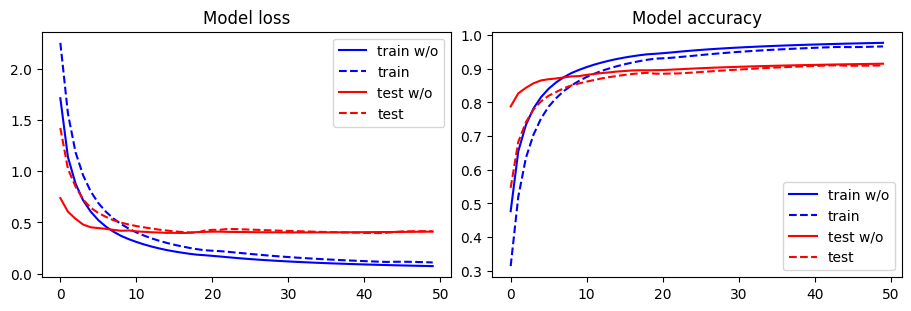

In [27]:
loss_track_simple, accuracy_track_simple = tracks_simple['loss'], tracks_simple['accuracy']
loss_track, accuracy_track = tracks['loss'], tracks['accuracy']
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(9, 3))

axes[0].plot(loss_track_simple['train'], 'b', label='train w/o')
axes[0].plot(loss_track['train'], 'b--', label='train')
axes[0].plot(loss_track_simple['test'], 'r', label='test w/o')
axes[0].plot(loss_track['test'], 'r--', label='test')
axes[0].set_title('Model loss')
axes[0].legend()

axes[1].plot(accuracy_track_simple['train'], 'b', label='train w/o')
axes[1].plot(accuracy_track['train'], 'b--', label='train')
axes[1].plot(accuracy_track_simple['test'], 'r', label='test w/o')
axes[1].plot(accuracy_track['test'], 'r--', label='test')

axes[1].set_title('Model accuracy')
axes[1].legend()
plt.show()


## LSTM

Модель LSTM состоит из двух частей: первая часть - сверточная, аналогичная рассмотренной выше; вторая - рекуррентная. В качестве рекуррентного слоя используется двунаправленный LSTM, после него - линейный слой (в отличие от архитектуры CNN, одномерный). Для использования рекуррентного слоя необходимо изменить форму тензора, что и отображено в функции `forward()`. 

In [28]:
# initial size (N, 3, 50, 200)
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), padding=1)
        nn.init.xavier_uniform_(self.conv1.weight)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        nn.init.xavier_uniform_(self.conv2.weight)

        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.lstm = nn.LSTM(768, 64, bidirectional=True, batch_first=True)

        self.final = nn.Linear(128, 20)
        nn.init.xavier_uniform_(self.final.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        N, C, w, h = x.size()
        x = x.view(N, -1, h)
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        return self.final(x)
    


Подсчет точности модели LSTM также выполняется сравнением предсказанных букв с оригинальными. В данной ситуации, если длина слова не равна 5, то точность его предсказания считается равной 0. Для того, чтобы из вывода модели получить буквы, воспользуемся специальным декодером. Библиотека PyTorch встроенным декодером не обладает, поэтому используется сторонняя библиотека.

Также при тренировки модели будет изменяться `learning_rate` оптимизатора для избежания попадания в локальный минимум. Поэтому будет также отображен график изменения `lr` в зависимости от эпохи.

In [29]:
def accuracy_lstm(out, labels, decoder):
    out = nn.functional.log_softmax(out, dim=2)
    out = out.permute(1, 0, 2)

    beam_results, beam_scores, timesteps, out_len = decoder.decode(out)
    N = len(labels)
    acc = 0
    for i in range(N):
        preds = beam_results[i][0][:out_len[i][0]].numpy()
        if len(preds) == 5:
            acc += np.sum(preds == labels[i]) / 5
    return acc / N

In [30]:
def train_test_LSTM(model, loaders, optimizer, scheduler, decoder, epochs=1):
    model = model.to(device)
    loss_meter = {'train': ValueMeter(), 'test': ValueMeter()}
    accuracy_meter = {'train': ValueMeter(), 'test': ValueMeter()}

    loss_track = {'train': [], 'test': []}
    accuracy_track = {'train': [], 'test': []}
    lr = []

    for epoch in range(epochs):
        for mode in ['train', 'test']:
            with torch.set_grad_enabled(mode == 'train'):
                model.train() if mode == 'train' else model.eval()
                for x, y in tqdm(loaders[mode]):
                    
                    x = x.to(device, dtype=dtype)  # move to device, e.g. GPU
                    y = torch.stack(y, dim=1).to(device, dtype=torch.long)
                    
                    out = model(x)
                    T, N = out.size(0), out.size(1)
                
                    scores = nn.functional.log_softmax(out, dim=2)
                    input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.int32)
                    target_lengths = torch.full(size=(N,), fill_value=5, dtype=torch.int32)
                    
                    loss = criterion(scores, y, input_lengths=input_lengths, target_lengths=target_lengths)
                    acc = accuracy_lstm(out, y.cpu().numpy(), decoder)

                    if mode == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                    batch_size = y.shape[0]

                    loss_meter[mode].add(loss.item(), batch_size)
                    accuracy_meter[mode].add(acc, batch_size)
                    
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
        lr += [scheduler.get_last_lr()]
        print(f"Epoch: {epoch+1} ==== learning rate: {scheduler.get_last_lr()}")

    return {'loss': loss_track, 'accuracy': accuracy_track, 'learning_rate': lr}

In [31]:
loader_train = DataLoader(train_dataset, batch_size=8, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)

loaders = {'train': loader_train, 'test': loader_test}

In [32]:
model = LSTM_model()
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=epochs, steps_per_epoch=94, div_factor=10, pct_start=0.2)

criterion = torch.nn.CTCLoss(blank=19, zero_infinity=False)

labels_list = list(char2num.keys()) + list('_')
decoder = CTCBeamDecoder(labels_list, blank_id=19, log_probs_input=True, alpha=1)

In [33]:
tracks = train_test_LSTM(model, loaders, optimizer, scheduler, decoder, epochs=epochs)

100%|██████████| 94/94 [00:12<00:00,  7.72it/s]


[train] Epoch: 1 ==== Loss: 4.40764 ==== Accuracy: 0.00027


100%|██████████| 41/41 [00:02<00:00, 14.32it/s]


[test] Epoch: 1 ==== Loss: 3.31272 ==== Accuracy: 0.00000
Epoch: 1 ==== learning rate: [0.0010554613317121271]


100%|██████████| 94/94 [00:07<00:00, 12.58it/s]


[train] Epoch: 2 ==== Loss: 3.84962 ==== Accuracy: 0.00013


100%|██████████| 41/41 [00:03<00:00, 11.48it/s]


[test] Epoch: 2 ==== Loss: 3.29458 ==== Accuracy: 0.00000
Epoch: 2 ==== learning rate: [0.001220478233819499]


100%|██████████| 94/94 [00:06<00:00, 13.62it/s]


[train] Epoch: 3 ==== Loss: 3.64960 ==== Accuracy: 0.00009


100%|██████████| 41/41 [00:03<00:00, 12.00it/s]


[test] Epoch: 3 ==== Loss: 3.26635 ==== Accuracy: 0.00000
Epoch: 3 ==== learning rate: [0.0014909831253683888]


100%|██████████| 94/94 [00:07<00:00, 12.32it/s]


[train] Epoch: 4 ==== Loss: 3.50948 ==== Accuracy: 0.00007


100%|██████████| 41/41 [00:02<00:00, 14.33it/s]


[test] Epoch: 4 ==== Loss: 3.17725 ==== Accuracy: 0.00000
Epoch: 4 ==== learning rate: [0.0018603082012388153]


100%|██████████| 94/94 [00:08<00:00, 11.06it/s]


[train] Epoch: 5 ==== Loss: 3.31538 ==== Accuracy: 0.00005


100%|██████████| 41/41 [00:03<00:00, 13.34it/s]


[test] Epoch: 5 ==== Loss: 2.94988 ==== Accuracy: 0.00062
Epoch: 5 ==== learning rate: [0.0023193497900785816]


100%|██████████| 94/94 [00:08<00:00, 10.48it/s]


[train] Epoch: 6 ==== Loss: 3.01078 ==== Accuracy: 0.00872


100%|██████████| 41/41 [00:03<00:00, 13.07it/s]


[test] Epoch: 6 ==== Loss: 2.62748 ==== Accuracy: 0.02150
Epoch: 6 ==== learning rate: [0.0028567927550751035]


100%|██████████| 94/94 [00:09<00:00,  9.78it/s]


[train] Epoch: 7 ==== Loss: 2.69219 ==== Accuracy: 0.05226


100%|██████████| 41/41 [00:03<00:00, 12.61it/s]


[test] Epoch: 7 ==== Loss: 2.34397 ==== Accuracy: 0.08278
Epoch: 7 ==== learning rate: [0.003459389406202596]


100%|██████████| 94/94 [00:08<00:00, 10.46it/s]


[train] Epoch: 8 ==== Loss: 2.42516 ==== Accuracy: 0.09963


100%|██████████| 41/41 [00:03<00:00, 12.11it/s]


[test] Epoch: 8 ==== Loss: 2.11131 ==== Accuracy: 0.13294
Epoch: 8 ==== learning rate: [0.004112286048902481]


100%|██████████| 94/94 [00:08<00:00, 11.06it/s]


[train] Epoch: 9 ==== Loss: 2.20633 ==== Accuracy: 0.15054


100%|██████████| 41/41 [00:04<00:00, 10.15it/s]


[test] Epoch: 9 ==== Loss: 1.92899 ==== Accuracy: 0.18609
Epoch: 9 ==== learning rate: [0.0047993891199416385]


100%|██████████| 94/94 [00:07<00:00, 11.94it/s]


[train] Epoch: 10 ==== Loss: 2.02311 ==== Accuracy: 0.20005


100%|██████████| 41/41 [00:04<00:00,  8.89it/s]


[test] Epoch: 10 ==== Loss: 1.77441 ==== Accuracy: 0.23283
Epoch: 10 ==== learning rate: [0.005503761885389706]


100%|██████████| 94/94 [00:08<00:00, 11.65it/s]


[train] Epoch: 11 ==== Loss: 1.86717 ==== Accuracy: 0.24743


100%|██████████| 41/41 [00:05<00:00,  8.13it/s]


[test] Epoch: 11 ==== Loss: 1.64828 ==== Accuracy: 0.26661
Epoch: 11 ==== learning rate: [0.006208041922316235]


100%|██████████| 94/94 [00:09<00:00, 10.42it/s]


[train] Epoch: 12 ==== Loss: 1.73677 ==== Accuracy: 0.28652


100%|██████████| 41/41 [00:03<00:00, 12.47it/s]


[test] Epoch: 12 ==== Loss: 1.53742 ==== Accuracy: 0.29964
Epoch: 12 ==== learning rate: [0.006894869093500686]


100%|██████████| 94/94 [00:09<00:00, 10.20it/s]


[train] Epoch: 13 ==== Loss: 1.62295 ==== Accuracy: 0.32316


100%|██████████| 41/41 [00:03<00:00, 12.48it/s]


[test] Epoch: 13 ==== Loss: 1.44260 ==== Accuracy: 0.33276
Epoch: 13 ==== learning rate: [0.007547313465800855]


100%|██████████| 94/94 [00:09<00:00, 10.24it/s]


[train] Epoch: 14 ==== Loss: 1.52552 ==== Accuracy: 0.35409


100%|██████████| 41/41 [00:03<00:00, 12.72it/s]


[test] Epoch: 14 ==== Loss: 1.36752 ==== Accuracy: 0.35260
Epoch: 14 ==== learning rate: [0.008149292624214138]


100%|██████████| 94/94 [00:09<00:00, 10.19it/s]


[train] Epoch: 15 ==== Loss: 1.44012 ==== Accuracy: 0.38287


100%|██████████| 41/41 [00:03<00:00, 12.61it/s]


[test] Epoch: 15 ==== Loss: 1.29414 ==== Accuracy: 0.37499
Epoch: 15 ==== learning rate: [0.008685968095056739]


100%|██████████| 94/94 [00:09<00:00, 10.27it/s]


[train] Epoch: 16 ==== Loss: 1.36332 ==== Accuracy: 0.40975


100%|██████████| 41/41 [00:03<00:00, 12.66it/s]


[test] Epoch: 16 ==== Loss: 1.23026 ==== Accuracy: 0.39576
Epoch: 16 ==== learning rate: [0.009144111106635251]


100%|██████████| 94/94 [00:09<00:00, 10.18it/s]


[train] Epoch: 17 ==== Loss: 1.29483 ==== Accuracy: 0.43357


100%|██████████| 41/41 [00:03<00:00, 12.50it/s]


[test] Epoch: 17 ==== Loss: 1.17251 ==== Accuracy: 0.41646
Epoch: 17 ==== learning rate: [0.009512428671600006]


100%|██████████| 94/94 [00:08<00:00, 10.73it/s]


[train] Epoch: 18 ==== Loss: 1.23404 ==== Accuracy: 0.45419


100%|██████████| 41/41 [00:03<00:00, 11.02it/s]


[test] Epoch: 18 ==== Loss: 1.12395 ==== Accuracy: 0.43236
Epoch: 18 ==== learning rate: [0.009781841953219489]


100%|██████████| 94/94 [00:07<00:00, 11.78it/s]


[train] Epoch: 19 ==== Loss: 1.18057 ==== Accuracy: 0.47135


100%|██████████| 41/41 [00:04<00:00,  9.26it/s]


[test] Epoch: 19 ==== Loss: 1.07960 ==== Accuracy: 0.44729
Epoch: 19 ==== learning rate: [0.009945710053991676]


100%|██████████| 94/94 [00:07<00:00, 11.97it/s]


[train] Epoch: 20 ==== Loss: 1.13142 ==== Accuracy: 0.48842


100%|██████████| 41/41 [00:04<00:00,  9.19it/s]


[test] Epoch: 20 ==== Loss: 1.03743 ==== Accuracy: 0.46243
Epoch: 20 ==== learning rate: [0.009999999563685422]


100%|██████████| 94/94 [00:08<00:00, 11.70it/s]


[train] Epoch: 21 ==== Loss: 1.08653 ==== Accuracy: 0.50390


100%|██████████| 41/41 [00:03<00:00, 10.92it/s]


[test] Epoch: 21 ==== Loss: 1.00054 ==== Accuracy: 0.47168
Epoch: 21 ==== learning rate: [0.00999606277771523]


100%|██████████| 94/94 [00:08<00:00, 10.67it/s]


[train] Epoch: 22 ==== Loss: 1.04709 ==== Accuracy: 0.51634


100%|██████████| 41/41 [00:03<00:00, 12.64it/s]


[test] Epoch: 22 ==== Loss: 0.96929 ==== Accuracy: 0.47958
Epoch: 22 ==== learning rate: [0.009984422502160032]


100%|██████████| 94/94 [00:09<00:00, 10.25it/s]


[train] Epoch: 23 ==== Loss: 1.01115 ==== Accuracy: 0.52795


100%|██████████| 41/41 [00:03<00:00, 12.55it/s]


[test] Epoch: 23 ==== Loss: 0.93711 ==== Accuracy: 0.49194
Epoch: 23 ==== learning rate: [0.009965096685481028]


100%|██████████| 94/94 [00:09<00:00, 10.22it/s]


[train] Epoch: 24 ==== Loss: 0.97707 ==== Accuracy: 0.54052


100%|██████████| 41/41 [00:03<00:00, 12.59it/s]


[test] Epoch: 24 ==== Loss: 0.90702 ==== Accuracy: 0.50382
Epoch: 24 ==== learning rate: [0.009938115126686775]


100%|██████████| 94/94 [00:09<00:00, 10.23it/s]


[train] Epoch: 25 ==== Loss: 0.94499 ==== Accuracy: 0.55315


100%|██████████| 41/41 [00:03<00:00, 12.46it/s]


[test] Epoch: 25 ==== Loss: 0.88105 ==== Accuracy: 0.51237
Epoch: 25 ==== learning rate: [0.009903519429385272]


100%|██████████| 94/94 [00:09<00:00, 10.27it/s]


[train] Epoch: 26 ==== Loss: 0.91630 ==== Accuracy: 0.56268


100%|██████████| 41/41 [00:03<00:00, 12.60it/s]


[test] Epoch: 26 ==== Loss: 0.85599 ==== Accuracy: 0.52257
Epoch: 26 ==== learning rate: [0.00986136293763421]


100%|██████████| 94/94 [00:09<00:00, 10.24it/s]


[train] Epoch: 27 ==== Loss: 0.88859 ==== Accuracy: 0.57315


100%|██████████| 41/41 [00:03<00:00, 12.59it/s]


[test] Epoch: 27 ==== Loss: 0.83225 ==== Accuracy: 0.53163
Epoch: 27 ==== learning rate: [0.009811710653688306]


100%|██████████| 94/94 [00:08<00:00, 10.54it/s]


[train] Epoch: 28 ==== Loss: 0.86391 ==== Accuracy: 0.58178


100%|██████████| 41/41 [00:03<00:00, 11.32it/s]


[test] Epoch: 28 ==== Loss: 0.80940 ==== Accuracy: 0.54014
Epoch: 28 ==== learning rate: [0.009754639137770537]


100%|██████████| 94/94 [00:08<00:00, 11.52it/s]


[train] Epoch: 29 ==== Loss: 0.83917 ==== Accuracy: 0.59196


100%|██████████| 41/41 [00:04<00:00,  9.45it/s]


[test] Epoch: 29 ==== Loss: 0.78838 ==== Accuracy: 0.54998
Epoch: 29 ==== learning rate: [0.00969023639002182]


100%|██████████| 94/94 [00:07<00:00, 11.85it/s]


[train] Epoch: 30 ==== Loss: 0.81614 ==== Accuracy: 0.60128


100%|██████████| 41/41 [00:04<00:00,  9.13it/s]


[test] Epoch: 30 ==== Loss: 0.76897 ==== Accuracy: 0.55772
Epoch: 30 ==== learning rate: [0.009618601714811182]


100%|██████████| 94/94 [00:07<00:00, 11.82it/s]


[train] Epoch: 31 ==== Loss: 0.79638 ==== Accuracy: 0.60775


100%|██████████| 41/41 [00:03<00:00, 10.68it/s]


[test] Epoch: 31 ==== Loss: 0.75295 ==== Accuracy: 0.56256
Epoch: 31 ==== learning rate: [0.00953984556761561]


100%|██████████| 94/94 [00:09<00:00, 10.40it/s]


[train] Epoch: 32 ==== Loss: 0.77681 ==== Accuracy: 0.61456


100%|██████████| 41/41 [00:04<00:00,  8.58it/s]


[test] Epoch: 32 ==== Loss: 0.73644 ==== Accuracy: 0.56947
Epoch: 32 ==== learning rate: [0.009454089384705721]


100%|██████████| 94/94 [00:08<00:00, 10.84it/s]


[train] Epoch: 33 ==== Loss: 0.75872 ==== Accuracy: 0.62097


100%|██████████| 41/41 [00:03<00:00, 12.58it/s]


[test] Epoch: 33 ==== Loss: 0.72239 ==== Accuracy: 0.57411
Epoch: 33 ==== learning rate: [0.009361465395899831]


100%|██████████| 94/94 [00:09<00:00, 10.23it/s]


[train] Epoch: 34 ==== Loss: 0.74114 ==== Accuracy: 0.62772


100%|██████████| 41/41 [00:03<00:00, 12.62it/s]


[test] Epoch: 34 ==== Loss: 0.70889 ==== Accuracy: 0.57783
Epoch: 34 ==== learning rate: [0.009262116420675159]


100%|██████████| 94/94 [00:09<00:00, 10.15it/s]


[train] Epoch: 35 ==== Loss: 0.72423 ==== Accuracy: 0.63431


100%|██████████| 41/41 [00:03<00:00, 12.72it/s]


[test] Epoch: 35 ==== Loss: 0.69460 ==== Accuracy: 0.58409
Epoch: 35 ==== learning rate: [0.00915619564795054]


100%|██████████| 94/94 [00:09<00:00, 10.24it/s]


[train] Epoch: 36 ==== Loss: 0.70877 ==== Accuracy: 0.63936


100%|██████████| 41/41 [00:03<00:00, 12.59it/s]


[test] Epoch: 36 ==== Loss: 0.68189 ==== Accuracy: 0.58842
Epoch: 36 ==== learning rate: [0.009043866399880227]


100%|██████████| 94/94 [00:09<00:00, 10.13it/s]


[train] Epoch: 37 ==== Loss: 0.69388 ==== Accuracy: 0.64523


100%|██████████| 41/41 [00:03<00:00, 12.39it/s]


[test] Epoch: 37 ==== Loss: 0.66868 ==== Accuracy: 0.59365
Epoch: 37 ==== learning rate: [0.008925301880022959]


100%|██████████| 94/94 [00:09<00:00, 10.20it/s]


[train] Epoch: 38 ==== Loss: 0.67956 ==== Accuracy: 0.65125


100%|██████████| 41/41 [00:03<00:00, 12.62it/s]


[test] Epoch: 38 ==== Loss: 0.65600 ==== Accuracy: 0.59882
Epoch: 38 ==== learning rate: [0.008800684906274628]


100%|██████████| 94/94 [00:08<00:00, 10.80it/s]


[train] Epoch: 39 ==== Loss: 0.66577 ==== Accuracy: 0.65664


100%|██████████| 41/41 [00:03<00:00, 10.93it/s]


[test] Epoch: 39 ==== Loss: 0.64456 ==== Accuracy: 0.60343
Epoch: 39 ==== learning rate: [0.008670207628976334]


100%|██████████| 94/94 [00:08<00:00, 11.46it/s]


[train] Epoch: 40 ==== Loss: 0.65270 ==== Accuracy: 0.66208


100%|██████████| 41/41 [00:04<00:00,  9.47it/s]


[test] Epoch: 40 ==== Loss: 0.63341 ==== Accuracy: 0.60888
Epoch: 40 ==== learning rate: [0.00853407123463249]


100%|██████████| 94/94 [00:07<00:00, 11.76it/s]


[train] Epoch: 41 ==== Loss: 0.63996 ==== Accuracy: 0.66782


100%|██████████| 41/41 [00:04<00:00,  8.89it/s]


[test] Epoch: 41 ==== Loss: 0.62314 ==== Accuracy: 0.61280
Epoch: 41 ==== learning rate: [0.008392485635695812]


100%|██████████| 94/94 [00:07<00:00, 11.84it/s]


[train] Epoch: 42 ==== Loss: 0.62802 ==== Accuracy: 0.67265


100%|██████████| 41/41 [00:04<00:00, 10.10it/s]


[test] Epoch: 42 ==== Loss: 0.61406 ==== Accuracy: 0.61675
Epoch: 42 ==== learning rate: [0.00824566914689753]


100%|██████████| 94/94 [00:08<00:00, 11.12it/s]


[train] Epoch: 43 ==== Loss: 0.61676 ==== Accuracy: 0.67708


100%|██████████| 41/41 [00:03<00:00, 12.25it/s]


[test] Epoch: 43 ==== Loss: 0.60451 ==== Accuracy: 0.62101
Epoch: 43 ==== learning rate: [0.008093848148621902]


100%|██████████| 94/94 [00:09<00:00, 10.39it/s]


[train] Epoch: 44 ==== Loss: 0.60567 ==== Accuracy: 0.68194


100%|██████████| 41/41 [00:03<00:00, 12.62it/s]


[test] Epoch: 44 ==== Loss: 0.59624 ==== Accuracy: 0.62417
Epoch: 44 ==== learning rate: [0.00793725673784406]


100%|██████████| 94/94 [00:09<00:00, 10.20it/s]


[train] Epoch: 45 ==== Loss: 0.59526 ==== Accuracy: 0.68647


100%|██████████| 41/41 [00:03<00:00, 12.67it/s]


[test] Epoch: 45 ==== Loss: 0.58761 ==== Accuracy: 0.62780
Epoch: 45 ==== learning rate: [0.007776136367169456]


100%|██████████| 94/94 [00:09<00:00, 10.27it/s]


[train] Epoch: 46 ==== Loss: 0.58608 ==== Accuracy: 0.68994


100%|██████████| 41/41 [00:03<00:00, 12.76it/s]


[test] Epoch: 46 ==== Loss: 0.57961 ==== Accuracy: 0.63148
Epoch: 46 ==== learning rate: [0.007610735472531429]


100%|██████████| 94/94 [00:09<00:00, 10.16it/s]


[train] Epoch: 47 ==== Loss: 0.57642 ==== Accuracy: 0.69429


100%|██████████| 41/41 [00:03<00:00, 12.43it/s]


[test] Epoch: 47 ==== Loss: 0.57164 ==== Accuracy: 0.63530
Epoch: 47 ==== learning rate: [0.0074413090901210175]


100%|██████████| 94/94 [00:09<00:00, 10.13it/s]


[train] Epoch: 48 ==== Loss: 0.56694 ==== Accuracy: 0.69876


100%|██████████| 41/41 [00:03<00:00, 12.73it/s]


[test] Epoch: 48 ==== Loss: 0.56414 ==== Accuracy: 0.63923
Epoch: 48 ==== learning rate: [0.007268118463139627]


100%|██████████| 94/94 [00:08<00:00, 10.78it/s]


[train] Epoch: 49 ==== Loss: 0.55769 ==== Accuracy: 0.70311


100%|██████████| 41/41 [00:03<00:00, 10.94it/s]


[test] Epoch: 49 ==== Loss: 0.55647 ==== Accuracy: 0.64341
Epoch: 49 ==== learning rate: [0.007091430638980957]


100%|██████████| 94/94 [00:07<00:00, 11.76it/s]


[train] Epoch: 50 ==== Loss: 0.54875 ==== Accuracy: 0.70728


100%|██████████| 41/41 [00:04<00:00,  9.11it/s]


[test] Epoch: 50 ==== Loss: 0.54919 ==== Accuracy: 0.64703
Epoch: 50 ==== learning rate: [0.0069115180574632696]


100%|██████████| 94/94 [00:08<00:00, 11.69it/s]


[train] Epoch: 51 ==== Loss: 0.54017 ==== Accuracy: 0.71128


100%|██████████| 41/41 [00:04<00:00,  9.51it/s]


[test] Epoch: 51 ==== Loss: 0.54229 ==== Accuracy: 0.65027
Epoch: 51 ==== learning rate: [0.006728658130746944]


100%|██████████| 94/94 [00:08<00:00, 11.66it/s]


[train] Epoch: 52 ==== Loss: 0.53182 ==== Accuracy: 0.71515


100%|██████████| 41/41 [00:03<00:00, 11.29it/s]


[test] Epoch: 52 ==== Loss: 0.53554 ==== Accuracy: 0.65392
Epoch: 52 ==== learning rate: [0.006543132815585023]


100%|██████████| 94/94 [00:09<00:00,  9.62it/s]


[train] Epoch: 53 ==== Loss: 0.52359 ==== Accuracy: 0.71903


100%|██████████| 41/41 [00:04<00:00, 10.23it/s]


[test] Epoch: 53 ==== Loss: 0.52948 ==== Accuracy: 0.65673
Epoch: 53 ==== learning rate: [0.006355228178566343]


100%|██████████| 94/94 [00:08<00:00, 10.64it/s]


[train] Epoch: 54 ==== Loss: 0.51575 ==== Accuracy: 0.72280


100%|██████████| 41/41 [00:03<00:00, 12.53it/s]


[test] Epoch: 54 ==== Loss: 0.52355 ==== Accuracy: 0.65994
Epoch: 54 ==== learning rate: [0.006165233955021588]


100%|██████████| 94/94 [00:09<00:00, 10.21it/s]


[train] Epoch: 55 ==== Loss: 0.50806 ==== Accuracy: 0.72666


100%|██████████| 41/41 [00:03<00:00, 12.45it/s]


[test] Epoch: 55 ==== Loss: 0.51785 ==== Accuracy: 0.66272
Epoch: 55 ==== learning rate: [0.005973443102272408]


100%|██████████| 94/94 [00:09<00:00, 10.29it/s]


[train] Epoch: 56 ==== Loss: 0.50052 ==== Accuracy: 0.73055


100%|██████████| 41/41 [00:03<00:00, 12.60it/s]


[test] Epoch: 56 ==== Loss: 0.51226 ==== Accuracy: 0.66530
Epoch: 56 ==== learning rate: [0.005780151347912462]


100%|██████████| 94/94 [00:09<00:00, 10.17it/s]


[train] Epoch: 57 ==== Loss: 0.49314 ==== Accuracy: 0.73432


100%|██████████| 41/41 [00:03<00:00, 12.70it/s]


[test] Epoch: 57 ==== Loss: 0.50662 ==== Accuracy: 0.66825
Epoch: 57 ==== learning rate: [0.005585656733816909]


100%|██████████| 94/94 [00:09<00:00, 10.27it/s]


[train] Epoch: 58 ==== Loss: 0.48597 ==== Accuracy: 0.73815


100%|██████████| 41/41 [00:03<00:00, 12.72it/s]


[test] Epoch: 58 ==== Loss: 0.50128 ==== Accuracy: 0.67085
Epoch: 58 ==== learning rate: [0.005390259156583433]


100%|██████████| 94/94 [00:09<00:00, 10.40it/s]


[train] Epoch: 59 ==== Loss: 0.47907 ==== Accuracy: 0.74184


100%|██████████| 41/41 [00:03<00:00, 11.95it/s]


[test] Epoch: 59 ==== Loss: 0.49590 ==== Accuracy: 0.67378
Epoch: 59 ==== learning rate: [0.005194259905113429]


100%|██████████| 94/94 [00:08<00:00, 11.21it/s]


[train] Epoch: 60 ==== Loss: 0.47230 ==== Accuracy: 0.74545


100%|██████████| 41/41 [00:04<00:00,  9.93it/s]


[test] Epoch: 60 ==== Loss: 0.49097 ==== Accuracy: 0.67679
Epoch: 60 ==== learning rate: [0.004997961196046356]


100%|██████████| 94/94 [00:07<00:00, 11.79it/s]


[train] Epoch: 61 ==== Loss: 0.46561 ==== Accuracy: 0.74913


100%|██████████| 41/41 [00:04<00:00,  8.98it/s]


[test] Epoch: 61 ==== Loss: 0.48615 ==== Accuracy: 0.67966
Epoch: 61 ==== learning rate: [0.00480166570776358]


100%|██████████| 94/94 [00:08<00:00, 11.69it/s]


[train] Epoch: 62 ==== Loss: 0.45927 ==== Accuracy: 0.75239


100%|██████████| 41/41 [00:04<00:00,  9.86it/s]


[test] Epoch: 62 ==== Loss: 0.48123 ==== Accuracy: 0.68253
Epoch: 62 ==== learning rate: [0.004605676113680251]


100%|██████████| 94/94 [00:08<00:00, 11.32it/s]


[train] Epoch: 63 ==== Loss: 0.45305 ==== Accuracy: 0.75567


100%|██████████| 41/41 [00:03<00:00, 11.93it/s]


[test] Epoch: 63 ==== Loss: 0.47681 ==== Accuracy: 0.68503
Epoch: 63 ==== learning rate: [0.004410294615544839]


100%|██████████| 94/94 [00:08<00:00, 10.51it/s]


[train] Epoch: 64 ==== Loss: 0.44696 ==== Accuracy: 0.75888


100%|██████████| 41/41 [00:03<00:00, 12.78it/s]


[test] Epoch: 64 ==== Loss: 0.47242 ==== Accuracy: 0.68761
Epoch: 64 ==== learning rate: [0.0042158224774659315]


100%|██████████| 94/94 [00:09<00:00, 10.22it/s]


[train] Epoch: 65 ==== Loss: 0.44101 ==== Accuracy: 0.76199


100%|██████████| 41/41 [00:03<00:00, 12.78it/s]


[test] Epoch: 65 ==== Loss: 0.46823 ==== Accuracy: 0.68988
Epoch: 65 ==== learning rate: [0.004022559561384829]


100%|██████████| 94/94 [00:09<00:00, 10.19it/s]


[train] Epoch: 66 ==== Loss: 0.43511 ==== Accuracy: 0.76515


100%|██████████| 41/41 [00:03<00:00, 12.59it/s]


[test] Epoch: 66 ==== Loss: 0.46411 ==== Accuracy: 0.69246
Epoch: 66 ==== learning rate: [0.0038308038647101497]


100%|██████████| 94/94 [00:09<00:00, 10.23it/s]


[train] Epoch: 67 ==== Loss: 0.42935 ==== Accuracy: 0.76828


100%|██████████| 41/41 [00:03<00:00, 12.59it/s]


[test] Epoch: 67 ==== Loss: 0.46030 ==== Accuracy: 0.69490
Epoch: 67 ==== learning rate: [0.0036408510608274373]


100%|██████████| 94/94 [00:09<00:00, 10.19it/s]


[train] Epoch: 68 ==== Loss: 0.42373 ==== Accuracy: 0.77134


100%|██████████| 41/41 [00:03<00:00, 12.60it/s]


[test] Epoch: 68 ==== Loss: 0.45651 ==== Accuracy: 0.69744
Epoch: 68 ==== learning rate: [0.0034529940431922254]


100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


[train] Epoch: 69 ==== Loss: 0.41829 ==== Accuracy: 0.77423


100%|██████████| 41/41 [00:03<00:00, 11.07it/s]


[test] Epoch: 69 ==== Loss: 0.45281 ==== Accuracy: 0.69991
Epoch: 69 ==== learning rate: [0.0032675224737095565]


100%|██████████| 94/94 [00:08<00:00, 11.49it/s]


[train] Epoch: 70 ==== Loss: 0.41295 ==== Accuracy: 0.77715


100%|██████████| 41/41 [00:04<00:00,  9.52it/s]


[test] Epoch: 70 ==== Loss: 0.44912 ==== Accuracy: 0.70231
Epoch: 70 ==== learning rate: [0.003084722336096329]


100%|██████████| 94/94 [00:07<00:00, 11.88it/s]


[train] Epoch: 71 ==== Loss: 0.40771 ==== Accuracy: 0.77999


100%|██████████| 41/41 [00:04<00:00,  9.06it/s]


[test] Epoch: 71 ==== Loss: 0.44560 ==== Accuracy: 0.70469
Epoch: 71 ==== learning rate: [0.002904875494915121]


100%|██████████| 94/94 [00:08<00:00, 11.75it/s]


[train] Epoch: 72 ==== Loss: 0.40259 ==== Accuracy: 0.78282


100%|██████████| 41/41 [00:03<00:00, 10.68it/s]


[test] Epoch: 72 ==== Loss: 0.44220 ==== Accuracy: 0.70693
Epoch: 72 ==== learning rate: [0.0027282592609594787]


100%|██████████| 94/94 [00:08<00:00, 10.94it/s]


[train] Epoch: 73 ==== Loss: 0.39755 ==== Accuracy: 0.78554


100%|██████████| 41/41 [00:03<00:00, 12.51it/s]


[test] Epoch: 73 ==== Loss: 0.43889 ==== Accuracy: 0.70903
Epoch: 73 ==== learning rate: [0.0025551459636607592]


100%|██████████| 94/94 [00:10<00:00,  9.06it/s]


[train] Epoch: 74 ==== Loss: 0.39262 ==== Accuracy: 0.78828


100%|██████████| 41/41 [00:03<00:00, 11.62it/s]


[test] Epoch: 74 ==== Loss: 0.43577 ==== Accuracy: 0.71094
Epoch: 74 ==== learning rate: [0.0023858025311758934]


100%|██████████| 94/94 [00:09<00:00, 10.22it/s]


[train] Epoch: 75 ==== Loss: 0.38779 ==== Accuracy: 0.79093


100%|██████████| 41/41 [00:03<00:00, 12.78it/s]


[test] Epoch: 75 ==== Loss: 0.43280 ==== Accuracy: 0.71273
Epoch: 75 ==== learning rate: [0.0022204900788035196]


100%|██████████| 94/94 [00:09<00:00, 10.18it/s]


[train] Epoch: 76 ==== Loss: 0.38307 ==== Accuracy: 0.79354


100%|██████████| 41/41 [00:03<00:00, 12.77it/s]


[test] Epoch: 76 ==== Loss: 0.42986 ==== Accuracy: 0.71460
Epoch: 76 ==== learning rate: [0.002059463506363107]


100%|██████████| 94/94 [00:09<00:00, 10.11it/s]


[train] Epoch: 77 ==== Loss: 0.37844 ==== Accuracy: 0.79609


100%|██████████| 41/41 [00:03<00:00, 12.44it/s]


[test] Epoch: 77 ==== Loss: 0.42690 ==== Accuracy: 0.71654
Epoch: 77 ==== learning rate: [0.0019029711051579243]


100%|██████████| 94/94 [00:09<00:00, 10.16it/s]


[train] Epoch: 78 ==== Loss: 0.37390 ==== Accuracy: 0.79859


100%|██████████| 41/41 [00:03<00:00, 12.64it/s]


[test] Epoch: 78 ==== Loss: 0.42409 ==== Accuracy: 0.71845
Epoch: 78 ==== learning rate: [0.0017512541751278292]


100%|██████████| 94/94 [00:09<00:00, 10.12it/s]


[train] Epoch: 79 ==== Loss: 0.36945 ==== Accuracy: 0.80102


100%|██████████| 41/41 [00:03<00:00, 12.50it/s]


[test] Epoch: 79 ==== Loss: 0.42136 ==== Accuracy: 0.72037
Epoch: 79 ==== learning rate: [0.0016045466527822684]


100%|██████████| 94/94 [00:08<00:00, 10.51it/s]


[train] Epoch: 80 ==== Loss: 0.36511 ==== Accuracy: 0.80340


100%|██████████| 41/41 [00:03<00:00, 10.99it/s]


[test] Epoch: 80 ==== Loss: 0.41869 ==== Accuracy: 0.72213
Epoch: 80 ==== learning rate: [0.001463074750487127]


100%|██████████| 94/94 [00:08<00:00, 11.32it/s]


[train] Epoch: 81 ==== Loss: 0.36085 ==== Accuracy: 0.80575


100%|██████████| 41/41 [00:04<00:00,  9.62it/s]


[test] Epoch: 81 ==== Loss: 0.41608 ==== Accuracy: 0.72388
Epoch: 81 ==== learning rate: [0.001327056607661653]


100%|██████████| 94/94 [00:08<00:00, 11.72it/s]


[train] Epoch: 82 ==== Loss: 0.35670 ==== Accuracy: 0.80803


100%|██████████| 41/41 [00:04<00:00,  8.91it/s]


[test] Epoch: 82 ==== Loss: 0.41354 ==== Accuracy: 0.72559
Epoch: 82 ==== learning rate: [0.0011967019544232944]


100%|██████████| 94/94 [00:07<00:00, 11.88it/s]


[train] Epoch: 83 ==== Loss: 0.35262 ==== Accuracy: 0.81028


100%|██████████| 41/41 [00:03<00:00, 10.39it/s]


[test] Epoch: 83 ==== Loss: 0.41105 ==== Accuracy: 0.72737
Epoch: 83 ==== learning rate: [0.0010722117881990496]


100%|██████████| 94/94 [00:08<00:00, 11.01it/s]


[train] Epoch: 84 ==== Loss: 0.34863 ==== Accuracy: 0.81245


100%|██████████| 41/41 [00:03<00:00, 12.38it/s]


[test] Epoch: 84 ==== Loss: 0.40864 ==== Accuracy: 0.72905
Epoch: 84 ==== learning rate: [0.0009537780638020075]


100%|██████████| 94/94 [00:09<00:00, 10.25it/s]


[train] Epoch: 85 ==== Loss: 0.34472 ==== Accuracy: 0.81457


100%|██████████| 41/41 [00:03<00:00, 12.71it/s]


[test] Epoch: 85 ==== Loss: 0.40633 ==== Accuracy: 0.73070
Epoch: 85 ==== learning rate: [0.0008415833974509442]


100%|██████████| 94/94 [00:09<00:00, 10.18it/s]


[train] Epoch: 86 ==== Loss: 0.34091 ==== Accuracy: 0.81665


100%|██████████| 41/41 [00:03<00:00, 12.41it/s]


[test] Epoch: 86 ==== Loss: 0.40404 ==== Accuracy: 0.73236
Epoch: 86 ==== learning rate: [0.0007358007851893379]


100%|██████████| 94/94 [00:09<00:00, 10.02it/s]


[train] Epoch: 87 ==== Loss: 0.33717 ==== Accuracy: 0.81869


100%|██████████| 41/41 [00:03<00:00, 12.62it/s]


[test] Epoch: 87 ==== Loss: 0.40182 ==== Accuracy: 0.73392
Epoch: 87 ==== learning rate: [0.0006365933361380223]


100%|██████████| 94/94 [00:09<00:00, 10.18it/s]


[train] Epoch: 88 ==== Loss: 0.33351 ==== Accuracy: 0.82069


100%|██████████| 41/41 [00:03<00:00, 12.59it/s]


[test] Epoch: 88 ==== Loss: 0.39966 ==== Accuracy: 0.73547
Epoch: 88 ==== learning rate: [0.0005441140209927326]


100%|██████████| 94/94 [00:09<00:00, 10.23it/s]


[train] Epoch: 89 ==== Loss: 0.32993 ==== Accuracy: 0.82266


100%|██████████| 41/41 [00:03<00:00, 12.45it/s]


[test] Epoch: 89 ==== Loss: 0.39756 ==== Accuracy: 0.73707
Epoch: 89 ==== learning rate: [0.00045850543615439017]


100%|██████████| 94/94 [00:08<00:00, 10.46it/s]


[train] Epoch: 90 ==== Loss: 0.32642 ==== Accuracy: 0.82457


100%|██████████| 41/41 [00:03<00:00, 11.65it/s]


[test] Epoch: 90 ==== Loss: 0.39551 ==== Accuracy: 0.73862
Epoch: 90 ==== learning rate: [0.00037989958385578187]


100%|██████████| 94/94 [00:08<00:00, 11.29it/s]


[train] Epoch: 91 ==== Loss: 0.32299 ==== Accuracy: 0.82644


100%|██████████| 41/41 [00:04<00:00,  9.72it/s]


[test] Epoch: 91 ==== Loss: 0.39351 ==== Accuracy: 0.74007
Epoch: 91 ==== learning rate: [0.0003084176686236848]


100%|██████████| 94/94 [00:07<00:00, 11.82it/s]


[train] Epoch: 92 ==== Loss: 0.31963 ==== Accuracy: 0.82826


100%|██████████| 41/41 [00:04<00:00,  8.97it/s]


[test] Epoch: 92 ==== Loss: 0.39157 ==== Accuracy: 0.74148
Epoch: 92 ==== learning rate: [0.00024416991039027545]


100%|██████████| 94/94 [00:07<00:00, 11.78it/s]


[train] Epoch: 93 ==== Loss: 0.31634 ==== Accuracy: 0.83006


100%|██████████| 41/41 [00:04<00:00,  9.99it/s]


[test] Epoch: 93 ==== Loss: 0.38966 ==== Accuracy: 0.74293
Epoch: 93 ==== learning rate: [0.00018725537454197938]


100%|██████████| 94/94 [00:08<00:00, 11.08it/s]


[train] Epoch: 94 ==== Loss: 0.31313 ==== Accuracy: 0.83182


100%|██████████| 41/41 [00:03<00:00, 12.18it/s]


[test] Epoch: 94 ==== Loss: 0.38781 ==== Accuracy: 0.74428
Epoch: 94 ==== learning rate: [0.00013776181916782626]


100%|██████████| 94/94 [00:10<00:00,  9.02it/s]


[train] Epoch: 95 ==== Loss: 0.30997 ==== Accuracy: 0.83354


100%|██████████| 41/41 [00:03<00:00, 12.23it/s]


[test] Epoch: 95 ==== Loss: 0.38599 ==== Accuracy: 0.74560
Epoch: 95 ==== learning rate: [9.576555974283876e-05]


100%|██████████| 94/94 [00:09<00:00, 10.28it/s]


[train] Epoch: 96 ==== Loss: 0.30689 ==== Accuracy: 0.83523


100%|██████████| 41/41 [00:03<00:00, 12.68it/s]


[test] Epoch: 96 ==== Loss: 0.38421 ==== Accuracy: 0.74693
Epoch: 96 ==== learning rate: [6.133135145509998e-05]


100%|██████████| 94/94 [00:09<00:00, 10.15it/s]


[train] Epoch: 97 ==== Loss: 0.30387 ==== Accuracy: 0.83687


100%|██████████| 41/41 [00:03<00:00, 12.60it/s]


[test] Epoch: 97 ==== Loss: 0.38246 ==== Accuracy: 0.74826
Epoch: 97 ==== learning rate: [3.4512289357949965e-05]


100%|██████████| 94/94 [00:09<00:00, 10.23it/s]


[train] Epoch: 98 ==== Loss: 0.30091 ==== Accuracy: 0.83847


100%|██████████| 41/41 [00:03<00:00, 12.70it/s]


[test] Epoch: 98 ==== Loss: 0.38075 ==== Accuracy: 0.74956
Epoch: 98 ==== learning rate: [1.5349726501256596e-05]


100%|██████████| 94/94 [00:09<00:00, 10.14it/s]


[train] Epoch: 99 ==== Loss: 0.29801 ==== Accuracy: 0.84005


100%|██████████| 41/41 [00:03<00:00, 12.51it/s]


[test] Epoch: 99 ==== Loss: 0.37907 ==== Accuracy: 0.75084
Epoch: 99 ==== learning rate: [3.87321016801582e-06]


100%|██████████| 94/94 [00:09<00:00, 10.16it/s]


[train] Epoch: 100 ==== Loss: 0.29516 ==== Accuracy: 0.84159


100%|██████████| 41/41 [00:03<00:00, 12.57it/s]

[test] Epoch: 100 ==== Loss: 0.37743 ==== Accuracy: 0.75209
Epoch: 100 ==== learning rate: [1.0043631457778787e-07]


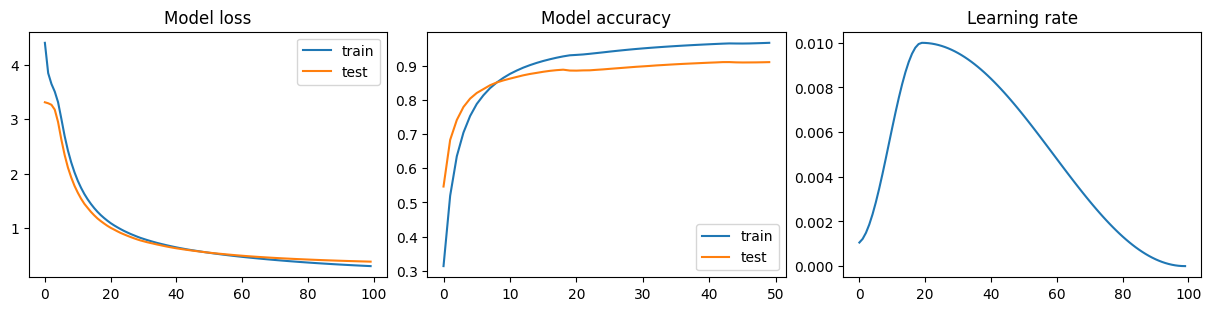

In [34]:
loss_track, acc_track = tracks['loss'], tracks['accuracy']

fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 3))
axes[0].plot(loss_track['train'], label='train')
axes[0].plot(loss_track['test'], label='test')
axes[0].set_title('Model loss')
axes[0].legend()

axes[1].plot(accuracy_track['train'], label='train')
axes[1].plot(accuracy_track['test'], label='test')
axes[1].set_title('Model accuracy')
axes[1].legend()

axes[2].plot(tracks['learning_rate'])
axes[2].set_title('Learning rate')
plt.show()

По полученным графикам потерь видно, что к 100-ой эпохе потери на тестовом датасете практически не изменяются, а на тренировочном медленно убывают. Это означает, что если продолжать тренировку, то модель может переобучиться на тренировочном датасете и потери на тестовом начнут расти. Аналогичная ситуация и с точностью. Точность на тестовом датасете установилась на уровне 73%, на тренировочном еще растет. При установке других оптимизаторов и дольшей тренировке возможно получить настолько же точные результаты, как и у сверточной нейросети.

## Выводы

Обе архитектуры нейронных сетей справляются с поставленной задачей. В случае со сверточной нейронной сетью точность достигает 91% на тренировочном датасете, с LSTM - порядка 75%. При этом если в сверточную нейросеть добавлять нормализацию и dropout, то скорость сходимости уменьшается. При параметре p=0.1 к 50-ой эпохе модели сходятся к одинаковым значениям loss и accuracy.